In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

!pwd

/content/drive/My Drive/Colab Notebooks


In [20]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.6.0
Is using GPU? False


In [33]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [34]:
image_size = (180, 180)
batch_size = 32

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1500, 32, 32, 3) (1500, 3)
(300, 32, 32, 3) (300, 3)


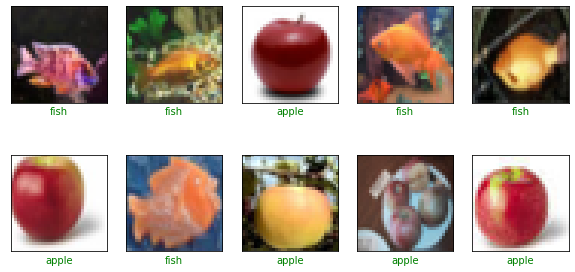

In [35]:
class_names = ['apple', 'fish', 'baby']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)


In [36]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 15, 64)       

In [37]:
%%time

h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, batch_size=256,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5', save_best_only=True,
                                          save_weights_only=False, monitor='val_accuracy')
    ]
)

Epoch 1/20
6/6 [==============================] - 9s 1s/step - loss: 1.0582 - accuracy: 0.5873 - val_loss: 1.0804 - val_accuracy: 0.4167
Epoch 2/20
6/6 [==============================] - 8s 1s/step - loss: 0.6340 - accuracy: 0.7567 - val_loss: 1.0821 - val_accuracy: 0.4800
Epoch 3/20
6/6 [==============================] - 8s 1s/step - loss: 0.4793 - accuracy: 0.8160 - val_loss: 1.0821 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.3628 - accuracy: 0.8587 - val_loss: 1.0762 - val_accuracy: 0.5500
Epoch 5/20
6/6 [==============================] - 8s 1s/step - loss: 0.3547 - accuracy: 0.8593 - val_loss: 1.0956 - val_accuracy: 0.5700
Epoch 6/20
6/6 [==============================] - 8s 1s/step - loss: 0.3187 - accuracy: 0.8767 - val_loss: 1.0867 - val_accuracy: 0.3467
Epoch 7/20
6/6 [==============================] - 8s 1s/step - loss: 0.2749 - accuracy: 0.9047 - val_loss: 1.0845 - val_accuracy: 0.3967
CPU times: user 1min 43s, sys: 2.93 s, to

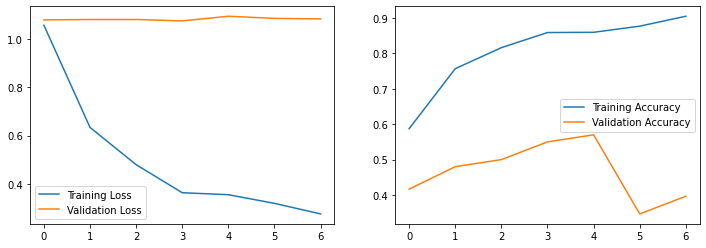

In [38]:
losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [39]:
model = tf.keras.models.load_model('models/model_0.570.h5')
preds = model.predict(x_test/255.)

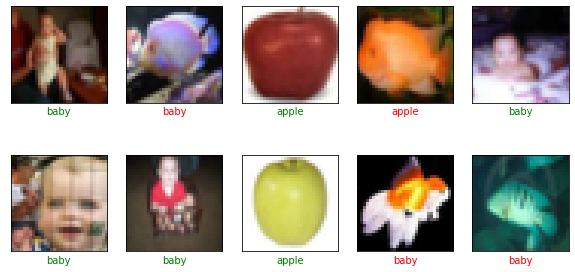

In [40]:
show_random_examples(x_test, y_test, preds)